<a href="https://colab.research.google.com/github/AliceRai/Portfolio/blob/main/Progetto_segmentazione_della_clientela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

LEGGIAMO IL DATASET

In [ ]:
URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv"

In [ ]:
df_original=pd.read_csv(URL)
df_original.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Iniziamo con un'analisi esplorativa del tipo di dato


In [ ]:
df_original.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


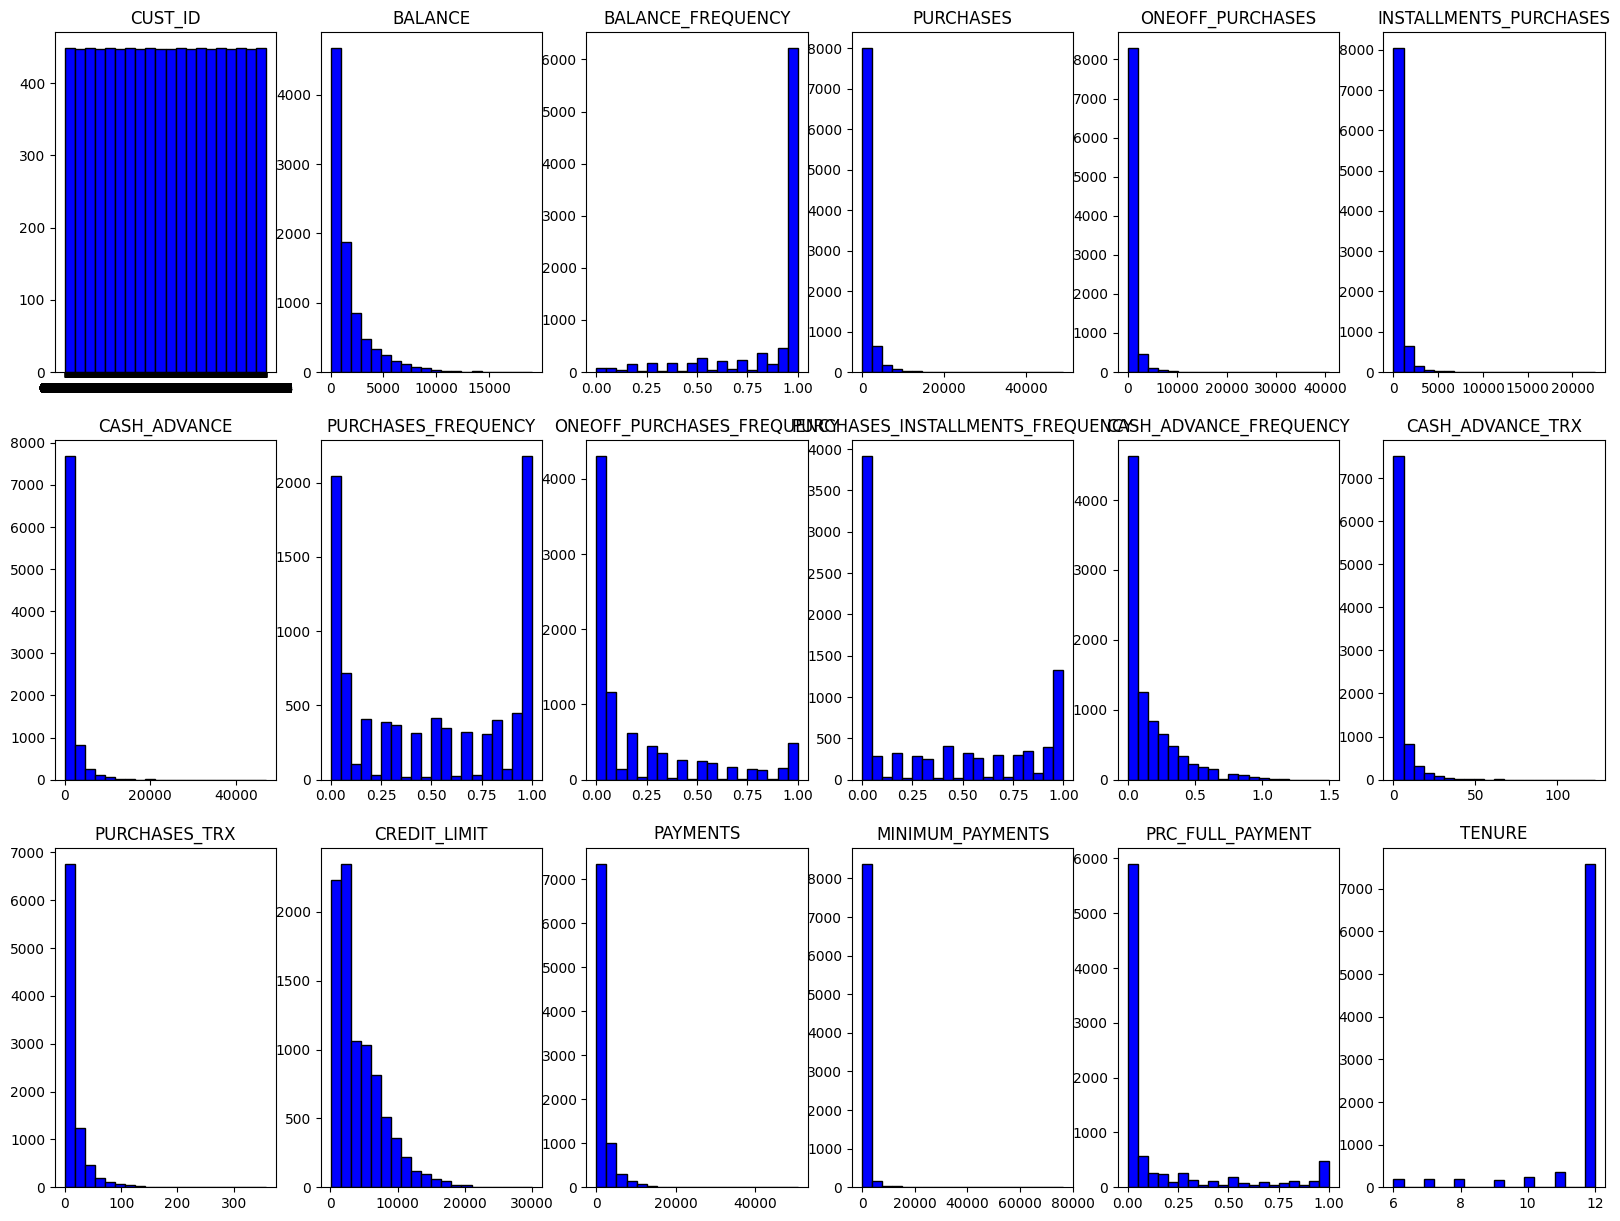

In [ ]:
# Creaiamo la griglia di subplot
fig, axes = plt.subplots(3, 6, figsize=(20, 15))
axes = axes.flatten()

# Creiamo gli istogrammi
for i, col in enumerate(df_original.columns):
    axes[i].hist(df_original[col], bins=20, color='blue', edgecolor='black')
    axes[i].set_title(col)

INSIGHT:dai grafici vediamo che i dati sono fortemente sbilanciati verso valori vicini allo zero. Decidiamo di procedere con il Power transformer per provare a ribilanciare il dataset.

PREPROCESSING


In [ ]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

INSIGHT:Vediamo che la colonna CUST_ID è l'unica di tipo objet, la togliamo per fare l'analisi.

In [ ]:
df=df_original.drop("CUST_ID", axis=1)

In [ ]:
df.isna().sum()

,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0
CASH_ADVANCE_FREQUENCY,0


INSIGHT:nel dataset ci sono dei valori mancanti nelle colonne CREDIT_LIMIT e MINIMUM_PAYMENTS che decidiamo di sostiuire con il valore medio

In [ ]:
#sostituzione valori mancanti con valore medio
df["CREDIT_LIMIT"]=df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].mean())
df["MINIMUM_PAYMENTS"]=df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mean())

Procediamo con il POWER TRANSFORMER per riequilibrare i dati

In [ ]:
pt = PowerTransformer()
df_transformed = pt.fit_transform(df)

In [ ]:
#traformiamo i dati in dataframe pandas per poterli visualizzare ancora nei grafici
df_transformed_plot = pd.DataFrame(df_transformed, columns=df.columns)

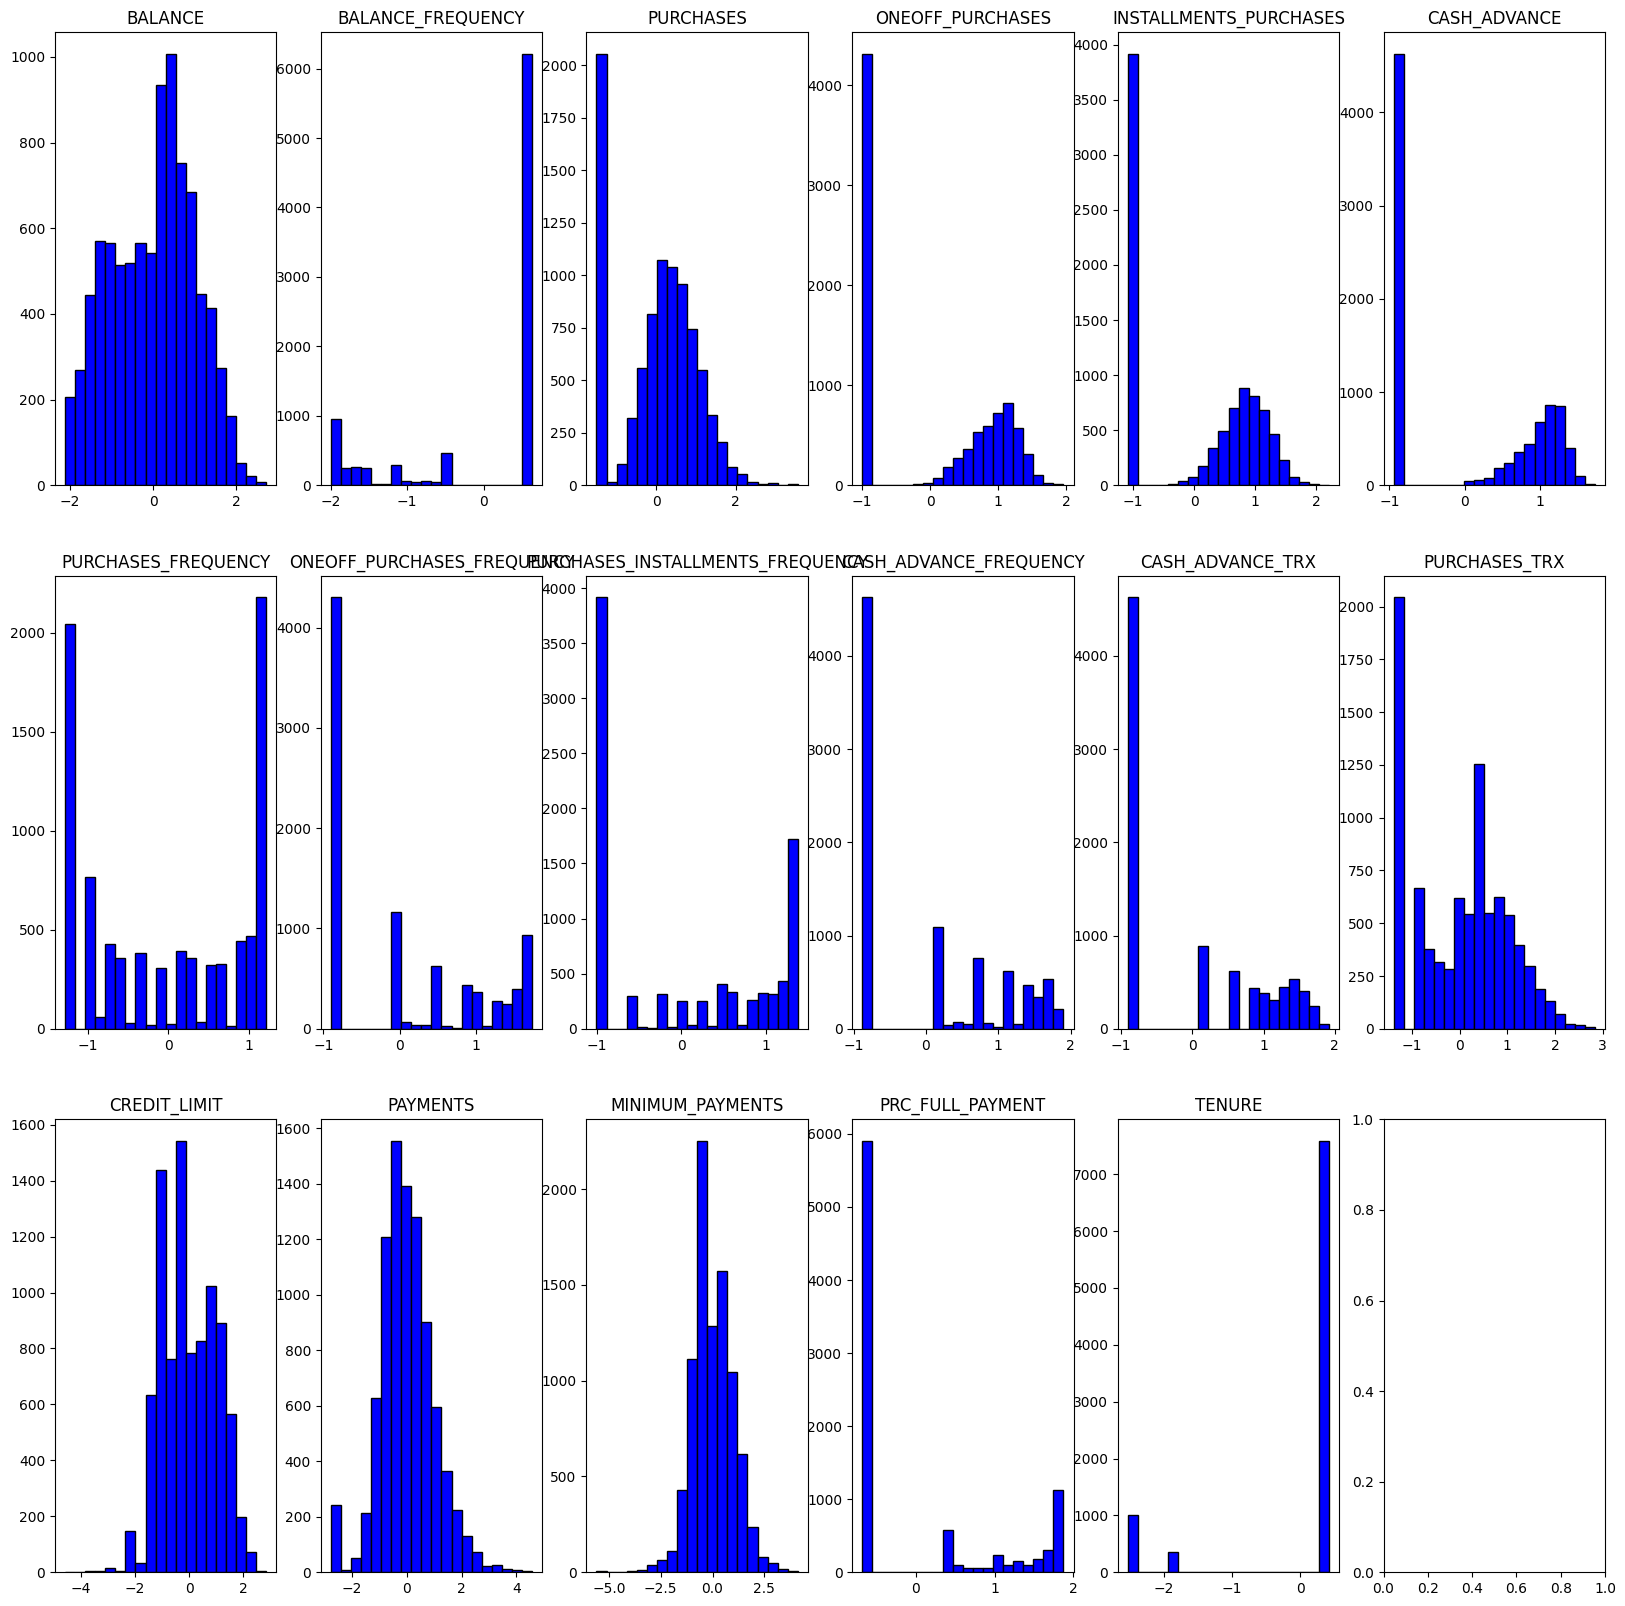

In [ ]:
# ripetiamo i grafici
fig, axes = plt.subplots(3, 6, figsize=(20, 20))
axes = axes.flatten()

# Generare gli istogrammi
for i, col in enumerate(df_transformed_plot.columns):
    axes[i].hist(df_transformed_plot[col], bins=20, color='blue', edgecolor='black')
    axes[i].set_title(col)

INSIGHT: i dati sono più equilibrati, ma comunque ci è difficile identificare le correlazioni tra le varie feature.
Procediamo quindi l'analisi con:
- standardizzazione dei dati
- Analisi PCA per ridurre la dimensionalità del dataset

In [ ]:
#standardizzazione
ss=StandardScaler()
df_ss=ss.fit_transform(df_transformed)

In [ ]:
#pca
pca=PCA()
pca.fit(df_ss)

PCA()

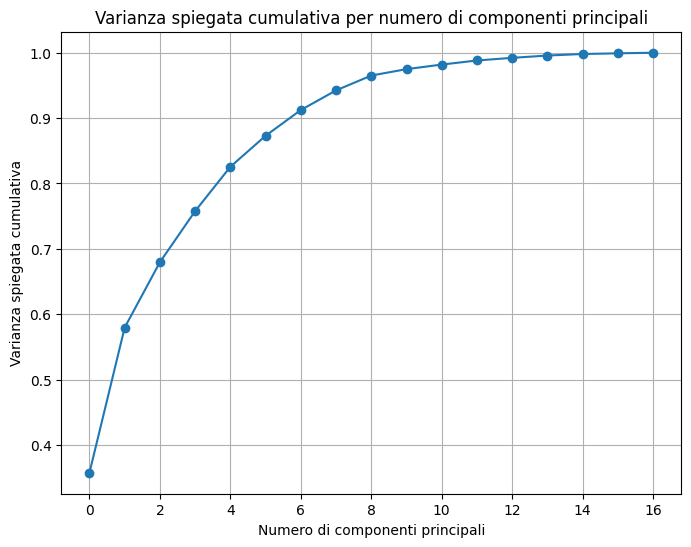

In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Grafico della varianza spiegata cumulativa
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('Varianza spiegata cumulativa per numero di componenti principali')
plt.grid()
plt.show()

In [ ]:
#calcolo dei valori cumulativi della varianza
np.cumsum(pca.explained_variance_ratio_)

array([0.35768855, 0.57969648, 0.67968827, 0.757779  , 0.82557501,
       0.87299914, 0.91235139, 0.94239448, 0.9651078 , 0.97488069,
       0.98188028, 0.98813151, 0.99215877, 0.99570456, 0.9980267 ,
       0.99910659, 1.        ])

INSIGHT: Il grafico della varianza spiegata cumulativa e il suo calcolo ci dicono che 5 componenti spiegano più dell'80% della varianza.
Procediamo quindi impostanto a 5 il numero di componenti della PCA

In [ ]:
pca=PCA(n_components=5)
df_pca=pca.fit_transform(df_ss)

Procediamo ora con la ricerca del numero ottimale di cluster tramite metodo SILHOUETTE e ELBOW

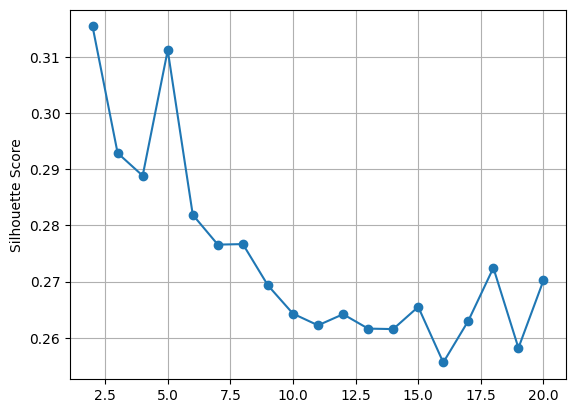

In [ ]:
#silhouette
clusters = range(2,21)
scores = []
for n in clusters:
    kmeans = KMeans(n_clusters = n, init="k-means++", n_init=10).fit(df_pca)
    score = silhouette_score(df_pca, kmeans.labels_)
    scores.append(score)

plt.plot(clusters,scores, marker='o')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

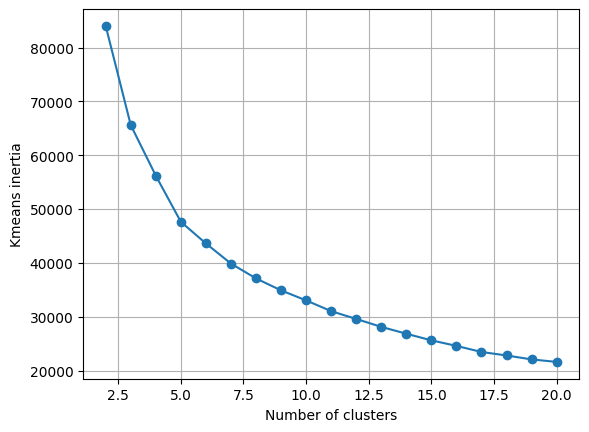

In [ ]:
#Elbow method
clusters = range(2,21)
inertia = []
for n in clusters:
    cluster = KMeans(n_clusters = n, init="k-means++", n_init=10).fit(df_pca)
    score = cluster.inertia_
    inertia.append(score)

plt.plot(clusters,inertia, marker="o")
plt.xlabel('Number of clusters')
plt.ylabel('Kmeans inertia')
plt.grid()
plt.show()

INSIGHT: il grafico silhouette sembra indicare un cluster ottimo di 2 mentre dal grafico elbow sembrerebbe essere 5, che rappresenta comunque il secondo valore del Silhouette score.

Proviamo entrambi i numeri di cluster e confrontiamo i risultati.

CLUSTER N.2

In [ ]:
kmeans2 = KMeans(n_clusters=2)
cluster_labels2 = kmeans2.fit_predict(df_pca)

In [ ]:
silhouette = silhouette_score(df_pca, cluster_labels2)
print(f'Silhouette Score con 2 cluster: {silhouette}')

Silhouette Score con 2 cluster: 0.3153973538885974


CLUSTER N.5

In [ ]:
kmeans5 = KMeans(n_clusters=5)
cluster_labels5 = kmeans5.fit_predict(df_pca)

In [ ]:
silhouette = silhouette_score(df_pca, cluster_labels5)
print(f'Silhouette Score con 5 cluster: {silhouette}')

Silhouette Score con 5 cluster: 0.25937484265727523


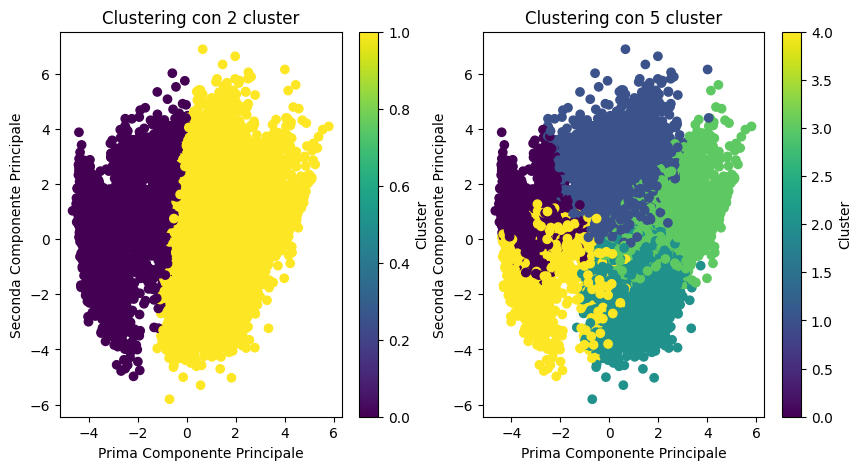

In [ ]:
# Visualizzazione dei cluster con le prime due componenti principati
plt.figure(figsize=(10, 5))

#cluster n2
plt.subplot(1,2,1)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels2, cmap='viridis', marker='o')
plt.title(f'Clustering con 2 cluster')
plt.xlabel('Prima Componente Principale')
plt.ylabel('Seconda Componente Principale')
plt.colorbar(label='Cluster')

#cluster n5
plt.subplot(1,2,2)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels5, cmap='viridis', marker='o')
plt.title(f'Clustering con 5 cluster')
plt.xlabel('Prima Componente Principale')
plt.ylabel('Seconda Componente Principale')
plt.colorbar(label='Cluster')

plt.show()

INSIGH: Sebbene la differenza in termini di Score sia molto bassa, l'analisi visiva mostra chiaramente che il clustering è migliore con solo 2 cluster

In [ ]:
#inseriamo i 2 cluster nel dataset di partenza
df_original['Cluster'] = cluster_labels2
df_original.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,1
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,0
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


Prepriamo il dataset con i cluster per l'analisi dei cluster

In [ ]:
#sostiuiamo i valori mancanti con la media dei valori
df_original["CREDIT_LIMIT"]=df_original["CREDIT_LIMIT"].fillna(df_original["CREDIT_LIMIT"].mean())
df_original["MINIMUM_PAYMENTS"]=df_original["MINIMUM_PAYMENTS"].fillna(df_original["MINIMUM_PAYMENTS"].mean())

In [ ]:
#Togliamo la colonna CUST_ID
df_original=df_original.drop("CUST_ID", axis=1)

ANALIZZIAMO PRIMA LE FREQUENZE DELLE VARIABILI PER I 2 CLUSTER E POI I VALORI MEDI.

LEGENDA: \
CLUSTER 0 --> BLU\
CLUSTER 1 --> ARANCIONE

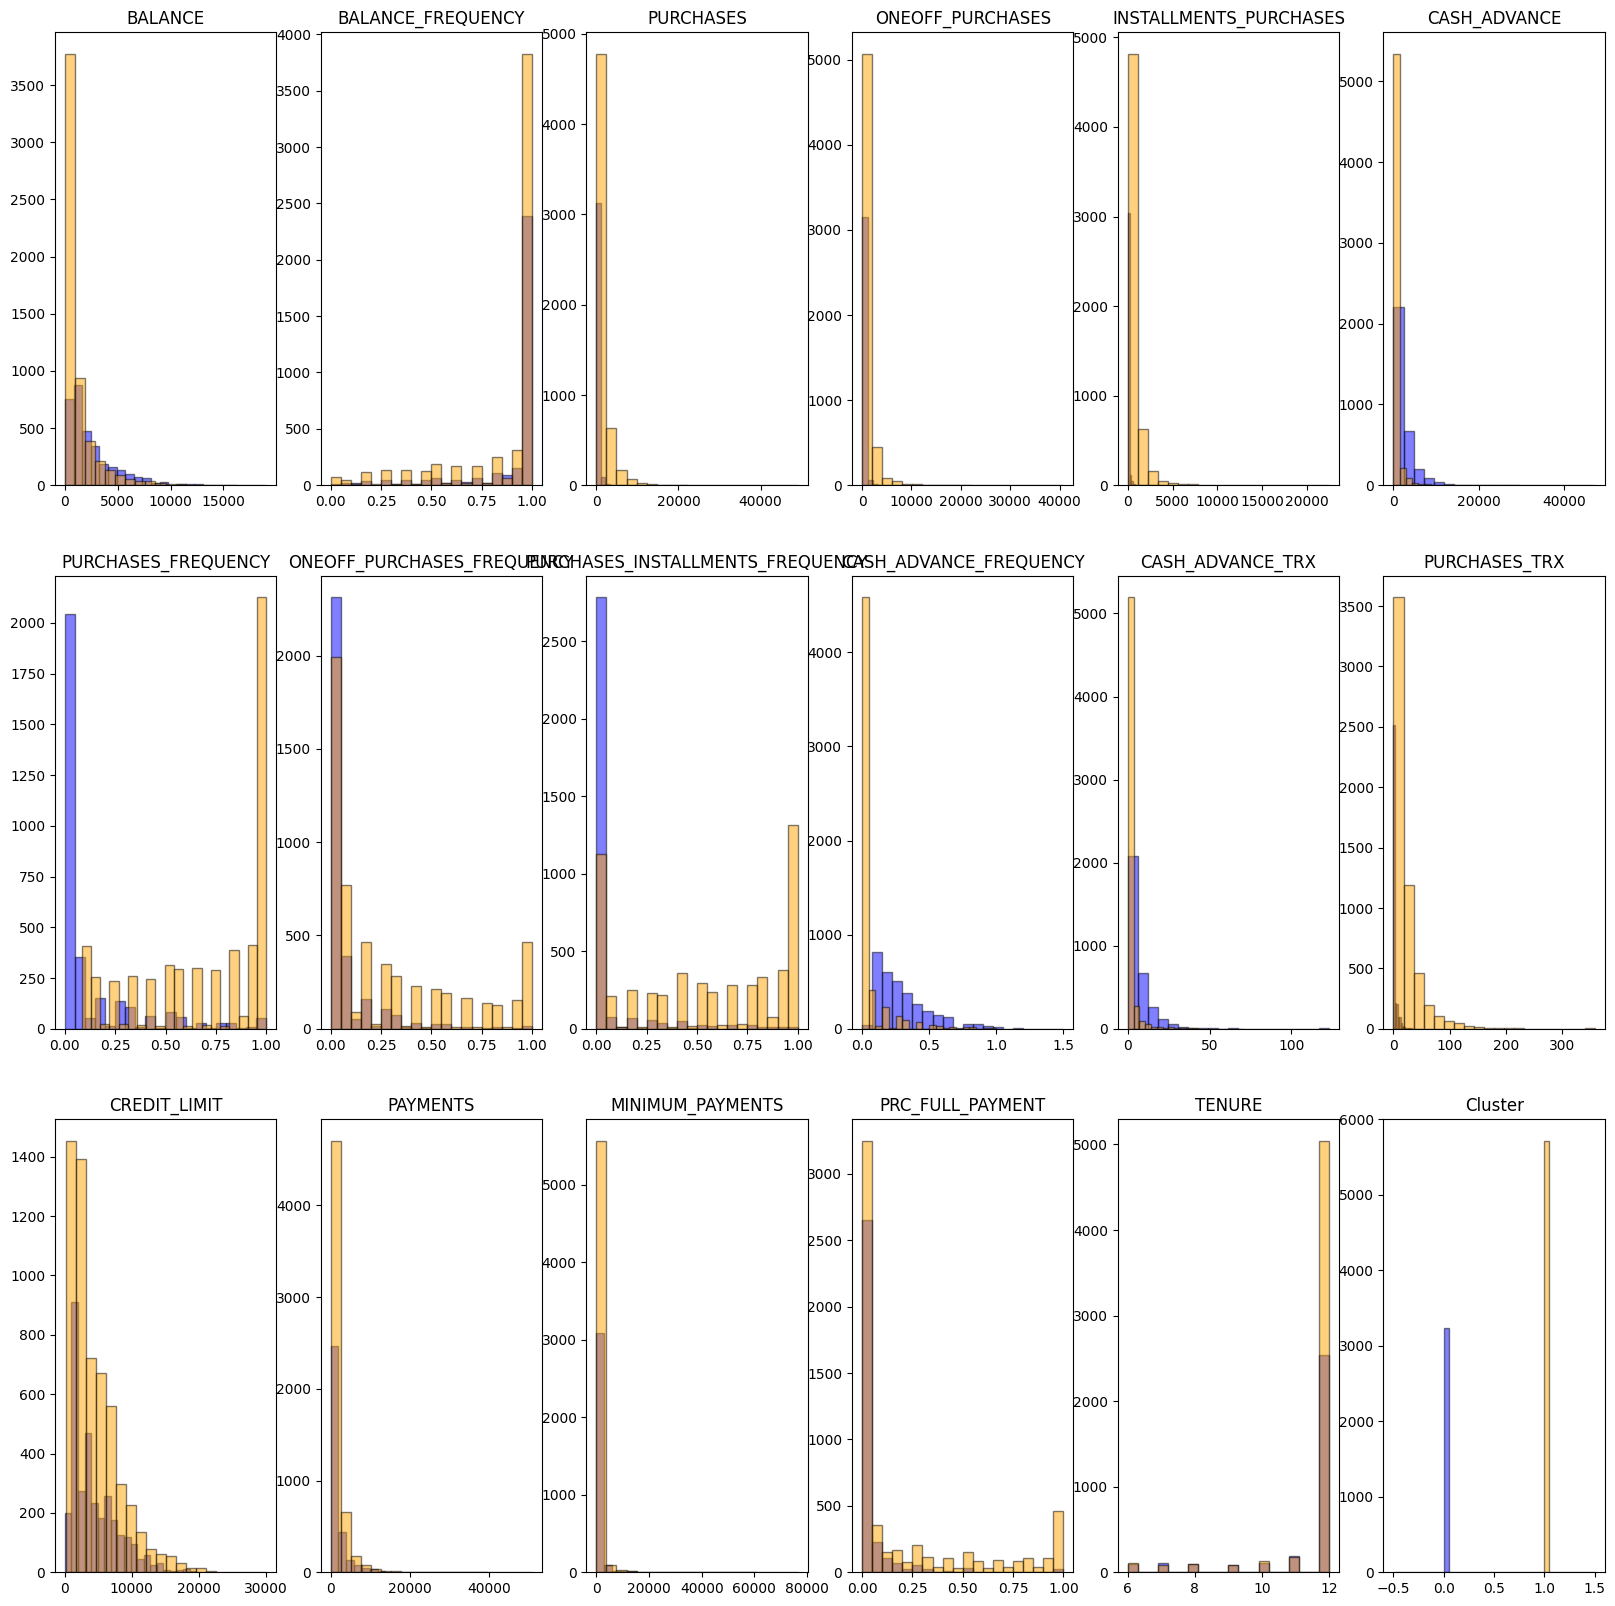

In [ ]:
# Creiamo la griglia di grafici
fig, axes = plt.subplots(3, 6, figsize=(20, 20))
axes = axes.flatten()

# Colori per i cluster
colors = {0: 'blue', 1: 'orange'}

# Creiamo gli istogrammi
for i, col in enumerate(df_original.columns):
    cluster0_data = df_original[df_original['Cluster'] == 0][col]
    cluster1_data = df_original[df_original['Cluster'] == 1][col]

    axes[i].hist(cluster0_data, bins=20, color=colors[0], alpha=0.5, edgecolor='black')
    axes[i].hist(cluster1_data, bins=20, color=colors[1], alpha=0.5, edgecolor='black')
    axes[i].set_title(col)

plt.show()

Vediamo ora i valori medi

In [ ]:
df_original.groupby("Cluster").mean().transpose()

Cluster,0,1
BALANCE,2410.255736,1085.716956
BALANCE_FREQUENCY,0.904489,0.861864
PURCHASES,164.839230,1477.765241
ONEOFF_PURCHASES,127.123181,855.830443
INSTALLMENTS_PURCHASES,37.846022,622.331328
CASH_ADVANCE,2142.962536,319.932222
PURCHASES_FREQUENCY,0.116524,0.701957
ONEOFF_PURCHASES_FREQUENCY,0.061275,0.282375
PURCHASES_INSTALLMENTS_FREQUENCY,0.053033,0.540709
CASH_ADVANCE_FREQUENCY,0.291670,0.046542


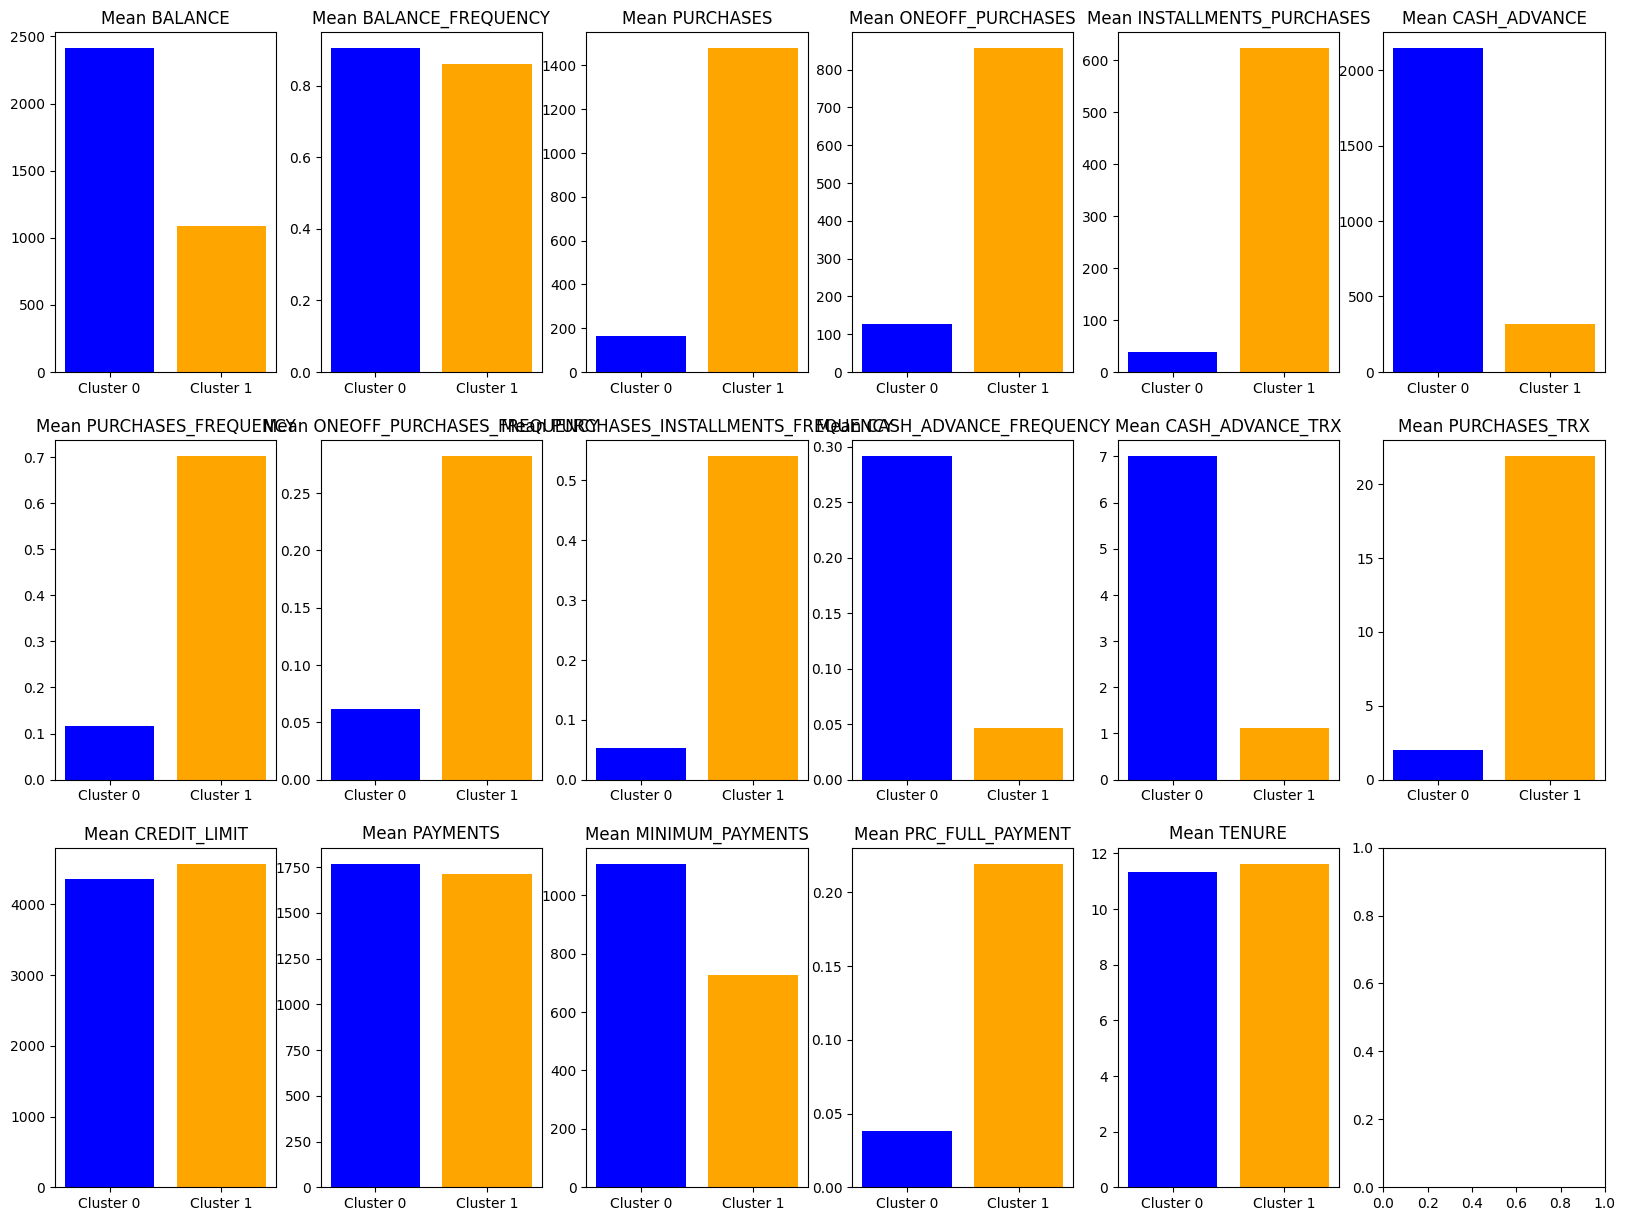

In [ ]:
# Calcolare i valori medi per ciascun cluster
mean_values = df_original.groupby('Cluster').mean()

# Colori per i cluster
colors = {0: 'blue', 1: 'orange'}

# Creiamo la griglia di grafici
fig, axes = plt.subplots(3,6, figsize=(20, 15))
axes = axes.flatten()

# Creiamo i grafici a barre
for i, col in enumerate(mean_values.columns):
    cluster_means = mean_values[col]

    #lista dei colori
    color_list = []
    for idx in cluster_means.index:
        color_list.append(colors[idx])

    #lista delle etichette degli assi x
    xtick_labels = []
    for idx in cluster_means.index:
        xtick_labels.append(f'Cluster {int(idx)}')

    axes[i].bar(cluster_means.index, cluster_means, color=color_list)
    axes[i].set_title(f'Mean {col}')
    axes[i].set_xticks(cluster_means.index)
    axes[i].set_xticklabels(xtick_labels)

plt.show()

INSIGHT: La lettura dei grafici evidenzia come il **CLUSTER O - BLU** sia composto da clienti che utilizzano una grande quantità di denaro (*miminum payments medio elevato*), principalmente contante(*cash_advance medio elevato*) per pochi acquisti (*frequenze e media degli acquisti basse*) e che quindi a questo scopo tengono sul conto una liquidità di denaro mediamente più alta (*balance*).\
Il **CLUSTER 1 - ARANCIONE** invece mostra clienti che acquistano più spesso  (*frequenze di acquisto e purchase trx elevate*), spendendo importi mediamente più bassi e che quindi hanno un saldo medio (*balance*) più basso sul conto.\

Si potrebbero attuare delle campagne di marketing volte a proporre al cluster 0 delle carte di credito con costi fissi molto bassi e un alto plafond per spostare la loro tipologia di spesa dal contante alla carta, mentre per sostenere gli acquisti del cluster 1 si potrebbe pensare di dare un premio (es. sconti su altri prodotti finanziari) al raggiungimento di un certo numero di transazioni con carta.

CREIAMO IL MODELLO DI CLASSIFICAZIONE


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

Ripetiamo il pre-processing sul dataset che ora contiene l'attribuzione dei cluster

In [ ]:
X=df_original.drop(["Cluster"], axis=1).values
y=df_original["Cluster"].values  #target

In [ ]:
#dividiamo il dataset in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)

Addestriamo il modello

In [ ]:
#attibuiamo una classe di peso perché abbiamo visto in precedenza che la distribuzione è sbilanciata
lr=LogisticRegression(class_weight="balanced")
lr.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
#eseguiamo le previsioni sulle classi

y_pred_train=lr.predict(X_train) #classi sul train set
y_pred_test=lr.predict(X_test)  #classi sul test set

Valutiamo il modello

In [ ]:
#calcoliamo le metriche prima sul set di addestramento
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2289
           1       0.98      0.97      0.98      3976

    accuracy                           0.97      6265
   macro avg       0.97      0.97      0.97      6265
weighted avg       0.97      0.97      0.97      6265



In [ ]:
#calcoliamo le metriche poi sul set di test
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       946
           1       0.98      0.96      0.97      1739

    accuracy                           0.96      2685
   macro avg       0.96      0.96      0.96      2685
weighted avg       0.96      0.96      0.96      2685



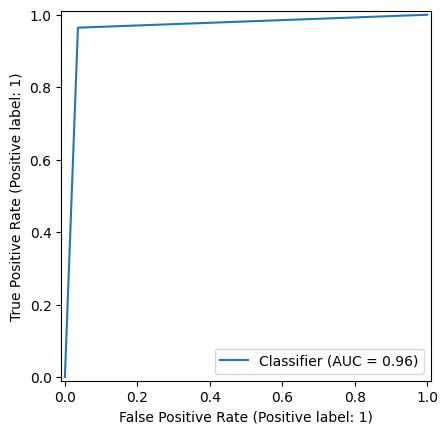

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred_test)

INSIGH: Riteniamo soddisfacenti i risultati delle metriche e della ROC curve